<a href="https://colab.research.google.com/github/charupandey-codes/Modeling-an-fMRI-time-series/blob/main/Jansen_rit_Vs_WW_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Nov  1 06:48:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install cupy-cuda12x

In [3]:
!pip install vbi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 33.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached swig-4.4.0-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (3.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 6.7 MB/s eta 0:00:00
Using cached swig-4.4.0-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.9 MB)
  Created wheel for vbi: filename=vbi-0.3-cp312-cp312-linux_x86_64.whl size=10908903 sha256=b9204666b174c038a6a657c198cfcc0a692341bb65c598c361792d910a71dc4a
  Stored in directory: /root/.cache/pip/wheels/14/35/5a/f474753d00953209eb69cf4e82d8c68726efe4fecc5bafa420
Successfully built vbi


In [6]:
 !pip install cmaes

In [7]:
 !pip install sbi

In [9]:
import torch
import pickle
import numpy as np
import networkx as nx
import sbi.utils as utils
import matplotlib.pyplot as plt
from sbi.analysis import pairplot
from helpers import plot_ts_pxx_jr
from vbi.sbi_inference import Inference
from vbi.models.cupy.jansen_rit import JR_sde
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [10]:
from vbi import report_cfg
from vbi import extract_features_list
from vbi import get_features_by_domain, get_features_by_given_names

In [11]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed);

In [12]:
LABESSIZE = 12
plt.rcParams['axes.labelsize'] = LABESSIZE
plt.rcParams['xtick.labelsize'] = LABESSIZE
plt.rcParams['ytick.labelsize'] = LABESSIZE

In [13]:
nn = 6
num_sim = 100
num_workers = 10
weights = nx.to_numpy_array(nx.complete_graph(nn))

In [14]:
par = {
    "weights": weights,
    "t_cut": 500,
    "t_end": 2000,
    "noise_amp": 0.05,
    "dt": 0.02,
    "num_sim": num_sim,
    "engine": "cpu",
    "seed": seed,
    "same_initial_state": True,
}

In [15]:
obj = Inference()
G_min, G_max = 0.0, 5.0
C1_min, C1_max = 135, 300
prior_min = [G_min, C1_min]
prior_max = [G_max, C1_max]
prior = utils.BoxUniform(low=torch.tensor(prior_min),
                         high=torch.tensor(prior_max))
theta = obj.sample_prior(prior, num_sim)
theta_np = theta.numpy().astype(float)
G = theta_np[:, 0]
C1 = theta_np[:, 1]
C1 = np.tile(C1, (nn, 1))
par['G'] = G
par['C1'] = C1

In [16]:
jr = JR_sde(par)
# print(jr())

In [17]:
data = jr.run()
print(data['x'].shape, data['t'].shape)
t = data['t']

100%|██████████| 100000/100000 [00:24<00:00, 4052.24it/s]

(75000, 6, 100) (75000,)


(75000,) (6, 75000)


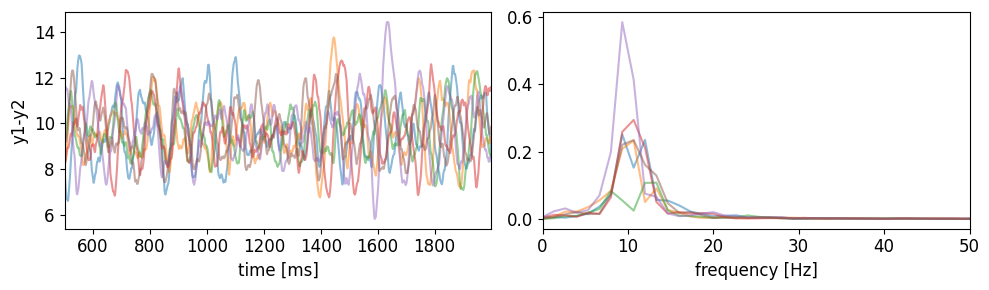

In [18]:
if 1:
    ts0 = data['x'][:, :, 0].T
    data0 = {"t": t, "x": ts0}
    info = np.isnan(ts0).sum()
    print(t.shape, ts0.shape)
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    plot_ts_pxx_jr(data0, par, ax, alpha=0.5)
    plt.tight_layout()
    plt.savefig("jr_ts_psd.png", dpi=300)

In [20]:
from vbi import get_features_by_domain, get_features_by_given_names, report_cfg
cfg = get_features_by_domain(domain="statistical")
cfg = get_features_by_given_names(cfg, names=['calc_std', 'calc_mean'])
report_cfg(cfg)

Selected features:
------------------
■ Domain: statistical
 ▢ Function:  calc_std
   ▫ description:  Computes the standard deviation of the signal.
   ▫ function   :  vbi.feature_extraction.features.calc_std
   ▫ parameters :  {'indices': None, 'verbose': False}
   ▫ tag        :  all
   ▫ use        :  yes
 ▢ Function:  calc_mean
   ▫ description:  Computes the mean of the signal.
   ▫ function   :  vbi.feature_extraction.features.calc_mean
   ▫ parameters :  {'indices': None, 'verbose': False}
   ▫ tag        :  all
   ▫ use        :  yes


In [21]:
ts = data['x']             # [nt, nn, ns]
ts = ts.transpose(2, 1, 0) # [ns, nn, nt]
print(ts.shape)

(100, 6, 75000)
